In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import torch
import copy
import random
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score

%matplotlib inline

In [2]:
dquery = np.load("synthetic_query_v1.npy").astype(np.float32)
dtest = np.load("synthetic_test_v1.npy").astype(np.float32)
dcf = np.load("64/synthetic-plaincf.npy").astype(np.float32)
dccf = np.load("64/synthetic-plaincf-2.npy").astype(np.float32)

In [3]:
query_x, query_y = dquery[:, 0:2], dquery[:, 2:3]
cf_x, cf_y = dcf[:, 0:2], dcf[:, 2:3]
ccf_x, ccf_y = dccf[:, 0:2], dccf[:, 2:3]
test_x, test_y = dtest[:, 0:2], dtest[:, 2:3]

In [4]:
scaler = MinMaxScaler()
query_x = scaler.fit_transform(query_x)
test_x = scaler.transform(test_x)
cf_x = scaler.transform(cf_x)
ccf_x = scaler.transform(ccf_x)

In [5]:
h= 0.02
x_min, x_max = dquery[:, 0].min() - .5, dquery[:, 0].max() + .5
y_min, y_max = dquery[:, 1].min() - .5, dquery[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                 np.arange(y_min, y_max, h))
dplot = np.c_[xx.ravel(), yy.ravel()]
_dplot = scaler.transform(dplot).astype(np.float32)
_dplot = torch.from_numpy(_dplot)

In [6]:
test_x = torch.from_numpy(test_x)
test_y = torch.from_numpy(test_y)

In [7]:
idx = [15, 2, 13]

In [8]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    model.train()
    prediction = []
    label = []

    for batch_idx, (data, target) in enumerate(iterator):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        preds = torch.round(output)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * len(target)
        label.extend(target.tolist())
        prediction.extend(preds.reshape(-1).tolist())

    acc = accuracy_score(label, prediction)
    f1 = f1_score(label, prediction)

    return epoch_loss / len(iterator.dataset), acc, f1

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    model.eval()
    prediction = []
    label = []

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(iterator):

            data, target = data.to(device), target.to(device)
            output = model(data)
            _, preds = torch.max(output, 1)
            preds = torch.round(output)
            loss = criterion(output, target)
            epoch_loss += loss.item() * len(target)
            label.extend(target.tolist())
            prediction.extend(preds.reshape(-1).tolist())
            
    acc = accuracy_score(label, prediction)
    f1 = f1_score(label, prediction)

    return epoch_loss / len(iterator.dataset), acc, f1

# DualCF

In [9]:
cf_sx, cf_sy = cf_x[idx], cf_y[idx]
ccf_sx, ccf_sy = ccf_x[idx], ccf_y[idx]
train_x, train_y = np.concatenate((cf_sx, ccf_sx), axis = 0), np.concatenate((cf_sy, ccf_sy), axis = 0)
Query = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
query_loader = DataLoader(Query, batch_size  = 32)

In [10]:
model1 = nn.Sequential(
    nn.Linear(2, 10),
    nn.ReLU(),
    nn.Linear(10, 1),
    nn.Sigmoid(),
)

optimizer = optim.Adam(model1.parameters(), lr = 0.005)
criterion = nn.BCELoss()
device = torch.device("cpu")
model1 = model1.to(device)
criterion = criterion.to(device)

for epoch in range(500):
    train_loss, train_acc, train_f1 = train(model1, query_loader, optimizer, criterion, device)
    if epoch % 50 == 0:
        print(f'Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f}')
    

Epoch: 0 | Train Loss: 0.6921 | Train Acc: 0.5000 | Train F1: 0.0000
Epoch: 50 | Train Loss: 0.6707 | Train Acc: 0.6667 | Train F1: 0.6667
Epoch: 100 | Train Loss: 0.6309 | Train Acc: 0.8333 | Train F1: 0.8571
Epoch: 150 | Train Loss: 0.5631 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 200 | Train Loss: 0.4788 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 250 | Train Loss: 0.3811 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 300 | Train Loss: 0.2897 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 350 | Train Loss: 0.2149 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 400 | Train Loss: 0.1591 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 450 | Train Loss: 0.1193 | Train Acc: 1.0000 | Train F1: 1.0000


In [11]:
test_pred = torch.round(model1(test_x))
agree1 = (test_pred == test_y).sum().float() / test_x.shape[0]
print(agree1)
S1 = torch.round(model1(_dplot)).detach().numpy()

tensor(0.9840)


# Model Extraction

In [55]:
query_sx, query_sy = query_x[idx], query_y[idx]
cf_sx, cf_sy = cf_x[idx], cf_y[idx]

train_x, train_y = np.concatenate((query_sx, cf_sx), axis = 0), np.concatenate((query_sy, cf_sy), axis = 0)
Query = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
query_loader = DataLoader(Query, batch_size  = 32)

In [56]:
model2 = nn.Sequential(
    nn.Linear(2, 10),
    nn.ReLU(),
    nn.Linear(10, 1),
    nn.Sigmoid(),
)


optimizer = optim.Adam(model2.parameters(), lr = 0.005)
criterion = nn.BCELoss()
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model2 = model2.to(device)
criterion = criterion.to(device)

for epoch in range(500):

    train_loss, train_acc, train_f1 = train(model2, query_loader, optimizer, criterion, device)
    
    if epoch % 50 == 0:
        print(f'Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f}')
    


Epoch: 0 | Train Loss: 0.7103 | Train Acc: 0.5000 | Train F1: 0.6667
Epoch: 50 | Train Loss: 0.6200 | Train Acc: 0.6667 | Train F1: 0.6667
Epoch: 100 | Train Loss: 0.4927 | Train Acc: 0.8333 | Train F1: 0.8000
Epoch: 150 | Train Loss: 0.3859 | Train Acc: 0.8333 | Train F1: 0.8000
Epoch: 200 | Train Loss: 0.3138 | Train Acc: 0.8333 | Train F1: 0.8000
Epoch: 250 | Train Loss: 0.2523 | Train Acc: 0.8333 | Train F1: 0.8000
Epoch: 300 | Train Loss: 0.1942 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 350 | Train Loss: 0.1444 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 400 | Train Loss: 0.1067 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 450 | Train Loss: 0.0801 | Train Acc: 1.0000 | Train F1: 1.0000


In [57]:
test_pred = torch.round(model2(test_x))
agree2 = (test_pred == test_y).sum().float() / test_x.shape[0]
print(agree2)
S2 = torch.round(model2(_dplot)).detach().numpy()

tensor(0.8627)


# Prediction Interface

In [52]:
query_sx, query_sy = query_x[idx], query_y[idx]
Query = TensorDataset(torch.from_numpy(query_sx), torch.from_numpy(query_sy))
query_loader = DataLoader(Query, batch_size  = 32)

In [53]:
model3 = nn.Sequential(
    nn.Linear(2, 10),
    nn.ReLU(),
    nn.Linear(10, 1),
    nn.Sigmoid(),
)


optimizer = optim.Adam(model3.parameters(), lr = 0.005)
criterion = nn.BCELoss()
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model3 = model3.to(device)
criterion = criterion.to(device)


for epoch in range(500):

    train_loss, train_acc, train_f1 = train(model3, query_loader, optimizer, criterion, device)
    
    if epoch % 50 == 0:
        print(f'Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f}')

Epoch: 0 | Train Loss: 0.6598 | Train Acc: 0.6667 | Train F1: 0.8000
Epoch: 50 | Train Loss: 0.5377 | Train Acc: 0.6667 | Train F1: 0.8000
Epoch: 100 | Train Loss: 0.3241 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 150 | Train Loss: 0.1409 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 200 | Train Loss: 0.0627 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 250 | Train Loss: 0.0333 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 300 | Train Loss: 0.0204 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 350 | Train Loss: 0.0138 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 400 | Train Loss: 0.0100 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 450 | Train Loss: 0.0075 | Train Acc: 1.0000 | Train F1: 1.0000


In [54]:
test_pred = torch.round(model3(test_x))
agree3 = (test_pred == test_y).sum().float() / test_x.shape[0]
print(agree3)
S3 = torch.round(model3(_dplot)).detach().numpy()

tensor(0.8520)


In [40]:
model = torch.load("synthetic.pt")
S = model(_dplot).detach().numpy()
S = S.reshape(xx.shape)
SS = S.round()

In [22]:
sample_positive = np.load("sample_positive.npy")
sample_negative = np.load("sample_negative.npy")

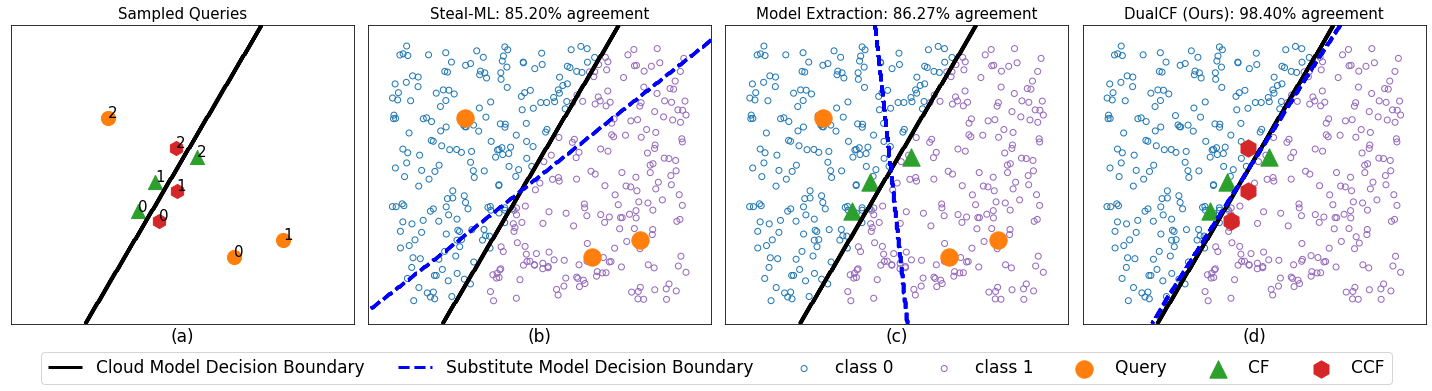

In [64]:
plt.rcParams["figure.figsize"] = (20, 5)
fig, axs = plt.subplots(1, 4)
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'
SS1 = S3.reshape(xx.shape).round()
SS2 = S2.reshape(xx.shape).round()
SS3 = S1.reshape(xx.shape).round()

CS = axs[0].contour(xx, yy, SS, colors = "black", linewidths = 3)

    
axs[0].scatter(dquery[idx, 0], dquery[idx, 1], marker = "o", s = 200, label = "Input", color = '#ff7f0e')
axs[0].scatter(dcf[idx, 0], dcf[idx, 1], marker = "^", s = 200, label = "CF", color = '#2ca02c')
axs[0].scatter(dccf[idx, 0], dccf[idx, 1], marker = "h", s = 200, label = "CCF", color = '#d62728')

for ii in range(3):
    i = idx[ii]
    axs[0].annotate(ii, (dquery[i, 0], dquery[i, 1]), fontsize = 15)
    axs[0].annotate(ii, (dcf[i, 0], dcf[i, 1]), fontsize = 15)
    axs[0].annotate(ii, (dccf[i, 0], dccf[i, 1]), fontsize = 15)
    
    
    

CS = axs[1].contour(xx, yy, SS, colors = 'black', linewidths = 3)
CS = axs[2].contour(xx, yy, SS, colors = 'black', linewidths = 3)
labels = ['Cloud Model Decision Boundary']
for i in range(len(labels)):
    CS.collections[i].set_label(labels[i])
CS = axs[3].contour(xx, yy, SS, colors = 'black', linewidths = 3)

CS2 = axs[1].contour(xx, yy, SS1, colors = "blue", linestyles= 'dashed', linewidths = 3)    
CS3 = axs[2].contour(xx, yy, SS2, colors = "blue", linestyles= 'dashed', linewidths = 3)
CS4 = axs[3].contour(xx, yy, SS3, colors = "blue", linestyles= 'dashed', linewidths = 3)

labels = ['Substitute Model Decision Boundary']
for i in range(len(labels)):
    CS3.collections[i].set_label(labels[i])


axs[1].scatter(sample_positive[0:200, 0], sample_positive[0:200, 1], edgecolors = '#1f77b4', label = "class 0", facecolors='none')
axs[1].scatter(sample_negative[0:200, 0], sample_negative[0:200, 1], edgecolors = '#9467bd', label = "class 1", facecolors = 'none')
axs[2].scatter(sample_positive[0:200, 0], sample_positive[0:200, 1], edgecolors = '#1f77b4', label = "class 0", facecolors='none')
axs[2].scatter(sample_negative[0:200, 0], sample_negative[0:200, 1], edgecolors = '#9467bd', label = "class 1", facecolors = 'none')
axs[3].scatter(sample_positive[0:200, 0], sample_positive[0:200, 1], edgecolors = '#1f77b4', label = "class 0", facecolors='none')
axs[3].scatter(sample_negative[0:200, 0], sample_negative[0:200, 1], edgecolors = '#9467bd', label = "class 1", facecolors = 'none')

axs[1].scatter(dquery[idx, 0], dquery[idx, 1], s= 300, color = '#ff7f0e', label = "Query")
#axs[1].scatter(dcf[idx, 0], dcf[idx, 1], marker = "^", s = 300, label = "CF", color = '#2ca02c')

axs[2].scatter(dquery[idx, 0], dquery[idx, 1], s= 300, color = '#ff7f0e', label = "Query")
axs[2].scatter(dcf[idx, 0], dcf[idx, 1], marker = "^", s = 300, label = "CF", color = '#2ca02c')

axs[3].scatter(dcf[idx, 0], dcf[idx, 1], marker = "^", s = 300, label = "CF", color = '#2ca02c')
axs[3].scatter(dccf[idx, 0], dccf[idx, 1], marker = "h", s = 300, label = "CCF", color = '#d62728')

axs[0].set_title("Sampled Queries",fontsize = 15)
axs[1].set_title("Steal-ML: {:.2f}% agreement".format(agree3 * 100),fontsize = 15)
axs[2].set_title("Model Extraction: {:.2f}% agreement".format(agree2 * 100),fontsize = 15)
axs[3].set_title("DualCF (Ours): {:.2f}% agreement".format(agree1 * 100),fontsize = 15)


axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[3].set_xticks([])
axs[3].set_yticks([])

axs[0].set_xlabel("(a)", fontsize = 17)
axs[1].set_xlabel("(b)", fontsize = 17)
axs[2].set_xlabel("(c)", fontsize = 17)
axs[3].set_xlabel("(d)", fontsize = 17)



handles, labels = axs[2].get_legend_handles_labels()
handles1, labels1 = axs[3].get_legend_handles_labels()
handles.append(handles1[-1])
labels.append(labels1[-1])

fig.legend(handles, labels, loc='lower center', ncol = 7, fontsize = 17, columnspacing = 2, bbox_to_anchor = (0.5, -0.1))
plt.tight_layout()
plt.savefig("figure 4.pdf", dpi = 600, bbox_inches = 'tight')
plt.show()